Natural Language Processing with Transformers

Chapter 4 - Multilingual Named Entity Recognition

We finetune a XLM-RoBERTa model to perform NER

In [1]:
import numpy as np
import pandas as pd


In [2]:
# Dataset has LOC, PER, ORG in IOB2 format

from datasets import get_dataset_config_names

xtreme_subsets = get_dataset_config_names("xtreme")

print(f"XTREME has {len(xtreme_subsets)} configurations")

XTREME has 183 configurations


In [3]:
panx_subsets = [s for s in xtreme_subsets if s.startswith("PAN")]

panx_subsets[:5]

['PAN-X.af', 'PAN-X.ar', 'PAN-X.bg', 'PAN-X.bn', 'PAN-X.de']

In [4]:
# We will make a "Swiss" corpus based on DE IT and FR and some English also
from collections import defaultdict
from datasets import DatasetDict, load_dataset 

langs = ["de", "fr", "it", "en"]
fracs = [0.629, 0.229, 0.084, 0.059]

# Return a DatasetDict if a key doesn't exist
panx_ch = defaultdict(DatasetDict)

for lang, frac in zip(langs, fracs):
    # single language dataset
    ds = load_dataset("xtreme", name=f"PAN-X.{lang}")
    # shuffle then take a fraction corresponding to required total frac in corpus
    for split in ds:
        panx_ch[lang][split] = (
        ds[split]
        .shuffle(seed=0)
        .select(range(int(frac * ds[split].num_rows))))
        
pd.DataFrame({lang: [panx_ch[lang]["train"].num_rows] for lang in langs}, index=["Number of training examples"])

Generating train split:   0%|          | 0/20000 [00:00<?, ? examples/s]

Generating validation split:   0%|          | 0/10000 [00:00<?, ? examples/s]

Generating test split:   0%|          | 0/10000 [00:00<?, ? examples/s]

Dataset xtreme downloaded and prepared to /root/.cache/huggingface/datasets/xtreme/PAN-X.de/1.0.0/349258adc25bb45e47de193222f95e68a44f7a7ab53c4283b3f007208a11bf7e. Subsequent calls will reuse this data.


  0%|          | 0/3 [00:00<?, ?it/s]

Generating train split:   0%|          | 0/20000 [00:00<?, ? examples/s]

Generating validation split:   0%|          | 0/10000 [00:00<?, ? examples/s]

Generating test split:   0%|          | 0/10000 [00:00<?, ? examples/s]

Dataset xtreme downloaded and prepared to /root/.cache/huggingface/datasets/xtreme/PAN-X.fr/1.0.0/349258adc25bb45e47de193222f95e68a44f7a7ab53c4283b3f007208a11bf7e. Subsequent calls will reuse this data.


  0%|          | 0/3 [00:00<?, ?it/s]

Generating train split:   0%|          | 0/20000 [00:00<?, ? examples/s]

Generating validation split:   0%|          | 0/10000 [00:00<?, ? examples/s]

Generating test split:   0%|          | 0/10000 [00:00<?, ? examples/s]

Dataset xtreme downloaded and prepared to /root/.cache/huggingface/datasets/xtreme/PAN-X.it/1.0.0/349258adc25bb45e47de193222f95e68a44f7a7ab53c4283b3f007208a11bf7e. Subsequent calls will reuse this data.


  0%|          | 0/3 [00:00<?, ?it/s]

Generating train split:   0%|          | 0/20000 [00:00<?, ? examples/s]

Generating validation split:   0%|          | 0/10000 [00:00<?, ? examples/s]

Generating test split:   0%|          | 0/10000 [00:00<?, ? examples/s]

Dataset xtreme downloaded and prepared to /root/.cache/huggingface/datasets/xtreme/PAN-X.en/1.0.0/349258adc25bb45e47de193222f95e68a44f7a7ab53c4283b3f007208a11bf7e. Subsequent calls will reuse this data.


  0%|          | 0/3 [00:00<?, ?it/s]

,de,fr,it,en
Number of training examples,12580,4580,1680,1180


In [5]:
# we have more DE than other langs, we will use it as startpoint for the transfer learning
print(panx_ch["de"]["train"][0])

{'tokens': ['2.000', 'Einwohnern', 'an', 'der', 'Danziger', 'Bucht', 'in', 'der', 'polnischen', 'Woiwodschaft', 'Pommern', '.'], 'ner_tags': [0, 0, 0, 0, 5, 6, 0, 0, 5, 5, 6, 0], 'langs': ['de', 'de', 'de', 'de', 'de', 'de', 'de', 'de', 'de', 'de', 'de', 'de']}


In [6]:
# what do the ner_tags actually correspond to - get from .features
reference_tags = panx_ch["de"]["train"].features["ner_tags"].feature
print(reference_tags)

ClassLabel(num_classes=7, names=['O', 'B-PER', 'I-PER', 'B-ORG', 'I-ORG', 'B-LOC', 'I-LOC'], id=None)


In [7]:
# use ClassLabel.int2str to create the tag names as strings
def create_tag_names(batch):
    return {"ner_tags_str": [reference_tags.int2str(idx) for idx in batch["ner_tags"]]}

panx_de = panx_ch["de"].map(create_tag_names)

  0%|          | 0/12580 [00:00<?, ?ex/s]

  0%|          | 0/6290 [00:00<?, ?ex/s]

  0%|          | 0/6290 [00:00<?, ?ex/s]

In [8]:
# look at first example in train
de_example = panx_de["train"][0]

pd.DataFrame( [de_example["tokens"], de_example["ner_tags_str"]], ["Tokens", "Tags"])

,0,1,2,3,4,5,6,7,8,9,10,11
Tokens,2.000,Einwohnern,an,der,Danziger,Bucht,in,der,polnischen,Woiwodschaft,Pommern,.
Tags,O,O,O,O,B-LOC,I-LOC,O,O,B-LOC,B-LOC,I-LOC,O


In [9]:
# good practice to check the imbalance of the entities across the t/v/t splits
from collections import Counter

split2freqs = defaultdict(Counter)

for split, dataset in panx_de.items():
    for row in dataset["ner_tags_str"]:
        for tag in row:
            if tag.startswith("B"):
                tag_type = tag.split("-")[1]
                split2freqs[split][tag_type] += 1

pd.DataFrame.from_dict(split2freqs, orient="index")

,LOC,ORG,PER
train,6186,5366,5810
validation,3172,2683,2893
test,3180,2573,3071


In [10]:
# XLM-R uses SentencePiece tokenizer; that is trained on raw text of 100 different languages

from transformers import AutoTokenizer

xlmr_model_name = "xlm-roberta-base"
xlmr_tokenizer = AutoTokenizer.from_pretrained(xlmr_model_name)



config.json:   0%|          | 0.00/615 [00:00<?, ?B/s]

sentencepiece.bpe.model:   0%|          | 0.00/5.07M [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/9.10M [00:00<?, ?B/s]

In [11]:
# example to show
example_text = "Jack Sparrow loves New York!"

xlmr_tokens = xlmr_tokenizer(example_text).tokens()
xlmr_tokens

['<s>', '▁Jack', '▁Spar', 'row', '▁love', 's', '▁New', '▁York', '!', '</s>']

p97 book - IMPORTANT:

For subwords e.g. "Christa" -> "Chr", "##ista"

we will assign the B-PER label to the first subword, and IGNORE THE FOLLOWING ONE(S)

We will indicate ignored subwords with IGN.

In [12]:
# p99
# Exercise - we PRETEND that there is no XLMRoberta for token classification (i.e no Head for the task we want)
# just to see if we can build it ourself as exercise:

import torch.nn as nn
from transformers import XLMRobertaConfig
from transformers.modeling_outputs import TokenClassifierOutput
from transformers.models.roberta.modeling_roberta import RobertaModel
from transformers.models.roberta.modeling_roberta import RobertaPreTrainedModel

class CUSTOM_XLMRobertaForTokenClassification(RobertaPreTrainedModel):
    config_class = XLMRobertaConfig # configuration object to initialize the model 
    
    def __init__(self, config):
        super().__init__(config)
        self.num_labels = config.num_labels
        
        # Load model body
        self.roberta = RobertaModel(config, add_pooling_layer=False)
        
        # Set up token classification head
        self.dropout = nn.Dropout(config.hidden_dropout_prob)
        self.classifier = nn.Linear(config.hidden_size, config.num_labels)
        
        # Load and initialize weights
        self.init_weights()
    
    def forward(self, input_ids=None, attention_mask=None, token_type_ids=None, labels=None, **kwargs):
        # Use model body to get encoder representations
        outputs = self.roberta(input_ids, attention_mask=attention_mask,
        token_type_ids=token_type_ids, **kwargs)
        # Apply classifier to encoder representation
        sequence_output = self.dropout(outputs[0])
        logits = self.classifier(sequence_output)
        # Calculate losses
        loss = None
        if labels is not None:
            loss_fct = nn.CrossEntropyLoss()
            loss = loss_fct(logits.view(-1, self.num_labels), labels.view(-1))
        # Return model output object
        return TokenClassifierOutput(loss=loss, logits=logits, hidden_states=outputs.hidden_states, attentions=outputs.attentions)
    

test = CUSTOM_XLMRobertaForTokenClassification.from_pretrained("roberta-base")

config.json:   0%|          | 0.00/481 [00:00<?, ?B/s]

You are using a model of type roberta to instantiate a model of type xlm-roberta. This is not supported for all configurations of models and can yield errors.


model.safetensors:   0%|          | 0.00/499M [00:00<?, ?B/s]

Some weights of CUSTOM_XLMRobertaForTokenClassification were not initialized from the model checkpoint at roberta-base and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [13]:
# (end of part about how you would build your own tokenclassification head)
# Loading a Custom Model p101

# from earlier:
# ClassLabel(num_classes=7, names=['O', 'B-PER', 'I-PER', 'B-ORG', 'I-ORG', 'B-LOC', 'I-LOC'], id=None)
# we are going to use this .names ^^^^^^ now to get the id2label etc

id2label = {idx:tag for idx,tag in enumerate(reference_tags.names)}
label2id = {tag:idx for idx,tag in enumerate(reference_tags.names)}

In [14]:
# We store the above mappings, and the reference_tags.num_classes, in an AutoConfig object
# When you pass keywords to from_pretrained(), you override the default values ofc

from transformers import AutoConfig

xlmr_config = AutoConfig.from_pretrained(xlmr_model_name,
                                        num_labels=reference_tags.num_classes,
                                        id2label=id2label,
                                        label2id=label2id)

In [15]:
# load model weights as usual, with the the additional config argument
import torch
from transformers import XLMRobertaForTokenClassification

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
# KAGGLE: turn on Accelerator GPU before run cell

xlmr_model = XLMRobertaForTokenClassification.from_pretrained(xlmr_model_name,
                                                             config=xlmr_config,
                                                             ).to(device)

model.safetensors:   0%|          | 0.00/1.12G [00:00<?, ?B/s]

Some weights of XLMRobertaForTokenClassification were not initialized from the model checkpoint at xlm-roberta-base and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [16]:
# check 1 - let's see if the tokenizer is working
input_ids = xlmr_tokenizer.encode(example_text, return_tensors="pt")

pd.DataFrame([xlmr_tokens, input_ids[0].numpy()], index=["Tokens", "Input IDs"])

,0,1,2,3,4,5,6,7,8,9
Tokens,<s>,▁Jack,▁Spar,row,▁love,s,▁New,▁York,!,</s>
Input IDs,0,21763,37456,15555,5161,7,2356,5753,38,2


In [17]:
# check 2 - pass inputs to model and extract predictions with argmax
outputs = xlmr_model(input_ids.to(device)).logits

predictions = torch.argmax(outputs, dim=-1)

print(f"Number of tokens in sequence: {len(xlmr_tokens)}")
print(f"Shape of outputs: {outputs.shape}")

# logits have the shape [batch_size, num_tokens, num_tags]

Number of tokens in sequence: 10
Shape of outputs: torch.Size([1, 10, 7])


In [18]:
preds = [reference_tags.names[p] for p in predictions[0].cpu().numpy()]
pd.DataFrame([xlmr_tokens, preds], index=["Tokens", "Tags"])

,0,1,2,3,4,5,6,7,8,9
Tokens,<s>,▁Jack,▁Spar,row,▁love,s,▁New,▁York,!,</s>
Tags,O,O,O,O,O,O,O,O,O,O


In [19]:
# seems to give only O ?????????? compared to example in book
# book is wrong - the weights are still randomly initialized??
print(outputs)
print("===")
print(predictions)

tensor([[[ 0.7402, -0.6636, -0.6215, -0.5031, -0.1908, -0.0203,  0.1403],
         [ 0.4484, -0.5321, -0.4032, -0.3921,  0.0244,  0.0369,  0.1332],
         [ 0.3872, -0.5667, -0.4375, -0.4612, -0.0045,  0.0595,  0.1141],
         [ 0.3634, -0.5641, -0.4245, -0.3745,  0.0646,  0.0263,  0.1225],
         [ 0.4474, -0.5678, -0.4394, -0.3793,  0.0481,  0.0076,  0.1923],
         [ 0.4758, -0.5520, -0.4528, -0.3592, -0.0458,  0.0281,  0.1984],
         [ 0.4601, -0.3724, -0.3678, -0.4029,  0.0502,  0.0915,  0.2082],
         [ 0.5050, -0.4129, -0.4229, -0.3503,  0.0957,  0.0155,  0.2366],
         [ 0.5331, -0.3767, -0.4398, -0.3598, -0.0154,  0.0569,  0.1850],
         [ 0.7008, -0.6370, -0.6010, -0.5346, -0.2292, -0.0212,  0.1137]]],
       device='cuda:0', grad_fn=<ViewBackward0>)
===
tensor([[0, 0, 0, 0, 0, 0, 0, 0, 0, 0]], device='cuda:0')


In [20]:
# wrap the previous steps into a function
def tag_text(text, tags, model, tokenizer):
    # Get tokens with special characters
    tokens = tokenizer(text).tokens()
    
    # Encode the sequence into IDs
    input_ids = xlmr_tokenizer(text, return_tensors="pt").input_ids.to(device)
    
    # Get predictions as distribution over 7 possible classes
    #outputs = model(inputs)[0] # <--- I THINK THIS IS WRONG IN BOOK ALSO ???
    outputs = model(input_ids)[0] 
    
    # Take argmax to get most likely class per token
    predictions = torch.argmax(outputs, dim=2)
    
    # Convert to DataFrame
    preds = [tags.names[p] for p in predictions[0].cpu().numpy()]
    
    return pd.DataFrame([tokens, preds], index=["Tokens", "Tags"])

In [21]:
# before training, need to tokenize inputs and prepare labels
# p103
words, labels = de_example["tokens"], de_example["ner_tags"]

print(words)
print(labels)

['2.000', 'Einwohnern', 'an', 'der', 'Danziger', 'Bucht', 'in', 'der', 'polnischen', 'Woiwodschaft', 'Pommern', '.']
[0, 0, 0, 0, 5, 6, 0, 0, 5, 5, 6, 0]


In [22]:
tokenized_input = xlmr_tokenizer(de_example["tokens"], is_split_into_words=True)
tokens = xlmr_tokenizer.convert_ids_to_tokens(tokenized_input["input_ids"])

pd.DataFrame([tokens], index=["Tokens"])

,0,1,2,3,4,5,6,7,8,9,...,15,16,17,18,19,20,21,22,23,24
Tokens,<s>,▁2.000,▁Einwohner,n,▁an,▁der,▁Dan,zi,ger,▁Buch,...,▁Wo,i,wod,schaft,▁Po,mmer,n,▁,.,</s>


In [23]:
# REMEMBER - we are following convention that only first subword is going to be associated with e.g. B-LOC

# tokenized_input has a word_ids() function:
word_ids = tokenized_input.word_ids()

pd.DataFrame([tokens, word_ids], index=["Tokens", "Word IDs"])

,0,1,2,3,4,5,6,7,8,9,...,15,16,17,18,19,20,21,22,23,24
Tokens,<s>,▁2.000,▁Einwohner,n,▁an,▁der,▁Dan,zi,ger,▁Buch,...,▁Wo,i,wod,schaft,▁Po,mmer,n,▁,.,</s>
Word IDs,None,0,1,1,2,3,4,4,4,5,...,9,9,9,9,10,10,10,11,11,None


In [24]:
"""Here we can see that word_ids has mapped each subword to the corresponding index
in the words sequence, so the first subword, “▁2.000”, is assigned the index 0, while
“▁Einwohner” and “n” are assigned the index 1 (since “Einwohnern” is the second
word in words). We can also see that special tokens like <s> and <\s> are mapped to
None. Let’s set –100 as the label for these special tokens and the subwords we wish to
mask during training:"""
previous_word_idx = None
label_ids = []

for word_idx in word_ids:
    if word_idx is None or word_idx == previous_word_idx:
        label_ids.append(-100)
    elif word_idx != previous_word_idx:
        label_ids.append(labels[word_idx])
    previous_word_idx = word_idx
    
labels = [id2label[l] if l != -100 else "IGN" for l in label_ids]
index = ["Tokens", "Word IDs", "Label IDs", "Labels"]
pd.DataFrame([tokens, word_ids, label_ids, labels], index=index)


# the -100 is because of ignore_index in PyTorch CrossEntropyLoss

,0,1,2,3,4,5,6,7,8,9,...,15,16,17,18,19,20,21,22,23,24
Tokens,<s>,▁2.000,▁Einwohner,n,▁an,▁der,▁Dan,zi,ger,▁Buch,...,▁Wo,i,wod,schaft,▁Po,mmer,n,▁,.,</s>
Word IDs,None,0,1,1,2,3,4,4,4,5,...,9,9,9,9,10,10,10,11,11,None
Label IDs,-100,0,0,-100,0,0,5,-100,-100,6,...,5,-100,-100,-100,6,-100,-100,0,-100,-100
Labels,IGN,O,O,IGN,O,O,B-LOC,IGN,IGN,I-LOC,...,B-LOC,IGN,IGN,IGN,I-LOC,IGN,IGN,O,IGN,IGN


In [25]:
# in the above DF you can see how the label IDs align with the tokens
# let's apply this now to our entire dataset with a function to map

def tokenize_and_align_labels(batch):
    tokenized_inputs = xlmr_tokenizer(batch["tokens"], truncation=True, is_split_into_words=True)
    labels = []
    for idx, label in enumerate(batch["ner_tags"]):
        word_ids = tokenized_inputs.word_ids(batch_index=idx)
        previous_word_idx = None
        label_ids = []
        for word_idx in word_ids:
            if word_idx is None or word_idx == previous_word_idx:
                label_ids.append(-100)
            else:
                label_ids.append(label[word_idx])
            previous_word_idx = word_idx
        labels.append(label_ids)
    
    tokenized_inputs["labels"] = labels
    
    return tokenized_inputs

In [26]:
# now we write a function to encode each split
# the remove_columns are specific to this PANX dataset of course (the langs part at least)
def encode_panx_dataset(corpus):
    return corpus.map(tokenize_and_align_labels, batched=True, remove_columns=['langs', 'ner_tags', 'tokens'])


# ENCODE THE GERMAN CORPUS:
panx_de_encoded = encode_panx_dataset(panx_ch["de"])

  0%|          | 0/13 [00:00<?, ?ba/s]

  0%|          | 0/7 [00:00<?, ?ba/s]

  0%|          | 0/7 [00:00<?, ?ba/s]

In [27]:
# define Performance metrics
# p105
!pip install seqeval

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)


     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 43.6/43.6 kB 1.5 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for seqeval: filename=seqeval-1.2.2-py3-none-any.whl size=16162 sha256=f27f74f6f8b4b58abab0cc1a53c9cbdff066f08cf57ea5b16a167c46b33e846e
  Stored in directory: /root/.cache/pip/wheels/1a/67/4a/ad4082dd7dfc30f2abfe4d80a2ed5926a506eb8a972b4767fa
Successfully built seqeval


In [28]:
from seqeval.metrics import classification_report

In [29]:
"""seqeval expects the predictions and labels as lists of lists, with each list
corresponding to a single example in our validation or test sets. To integrate these
metrics during training, we need a function that can take the outputs of the model
and convert them into the lists that seqeval expects. The following does the trick by
ensuring we ignore the label IDs associated with subsequent subwords:"""

import numpy as np

def align_predictions(predictions, label_ids):
    preds = np.argmax(predictions, axis=2)
    batch_size, seq_len = preds.shape
    labels_list, preds_list = [], []
    
    for batch_idx in range(batch_size):
        example_labels, example_preds = [], []
        
        for seq_idx in range(seq_len):
        # Ignore label IDs = -100
            if label_ids[batch_idx, seq_idx] != -100:
                example_labels.append(id2label[label_ids[batch_idx][seq_idx]])
                example_preds.append(id2label[preds[batch_idx][seq_idx]])
        
        labels_list.append(example_labels)
        preds_list.append(example_preds)
        
    return preds_list, labels_list

In [30]:
# --- Finetuning XLM RoBERTa ---
# finetune on the German subset of PAN-X

from transformers import TrainingArguments

num_epochs = 3
batch_size = 24
logging_steps = len(panx_de_encoded["train"]) // batch_size

model_name = f"{xlmr_model_name}-test-finetuned-panx-de"

training_args = TrainingArguments(output_dir=model_name,
                                  log_level="error",
                                  num_train_epochs=num_epochs,
                                  per_device_train_batch_size=batch_size,
                                  per_device_eval_batch_size=batch_size,
                                  evaluation_strategy="epoch",
                                  save_steps=1e6, # set save_steps to a large number to disable checkpointing and thus speed up training
                                  weight_decay=0.01,
                                  disable_tqdm=False,
                                  logging_steps=logging_steps,
                                  #load_best_model_at_end=True,
                                  report_to="none",
                                  push_to_hub=True)

In [31]:
from huggingface_hub import notebook_login
notebook_login()

In [32]:
# tell Trainer how to compute metrics on the validation set
# -> use align_predictions() we defined earlier to get the predictions+labels in the format needed by seqeval
# -> call f1_score on these 2 lists
from seqeval.metrics import f1_score

def compute_metrics(eval_pred):
    y_pred, y_true = align_predictions(eval_pred.predictions, eval_pred.label_ids)
    
    return {"f1": f1_score(y_true, y_pred)}


In [35]:
# data collator to pad each input sequence to largest sequence length in the batch

from transformers import DataCollatorForTokenClassification

# the ForTokenClassification means it will also pad the labels with -100 as well as the inputs

data_collator = DataCollatorForTokenClassification(xlmr_tokenizer)

In [36]:
"""We will train several models in the course of this chapter, so we’ll avoid initializing a
new model for every Trainer by creating a model_init() method. This method loads
an untrained model and is called at the beginning of the train() call:
"""
def model_init():
    return XLMRobertaForTokenClassification.from_pretrained(xlmr_model_name, config=xlmr_config).to(device)

In [40]:
from transformers import Trainer

trainer = Trainer(model_init=model_init,
                 args=training_args,
                 data_collator=data_collator,
                 compute_metrics=compute_metrics,
                 train_dataset=panx_de_encoded["train"],
                 eval_dataset=panx_de_encoded["validation"],
                 tokenizer=xlmr_tokenizer)

print("--- TRAINING ---", xlmr_model_name)
trainer.train()

--- TRAINING --- xlm-roberta-base


Epoch,Training Loss,Validation Loss,F1
1,0.260800,0.153963,0.830155
2,0.126300,0.132494,0.854320
3,0.080000,0.139859,0.861233


TrainOutput(global_step=1575, training_loss=0.1554795039078546, metrics={'train_runtime': 287.8359, 'train_samples_per_second': 131.116, 'train_steps_per_second': 5.472, 'total_flos': 865978637734056.0, 'train_loss': 0.1554795039078546, 'epoch': 3.0})

In [41]:
# to confirm it works let's test on a German phrase
text_de = "Jeff Dean ist ein Informatiker bei Google in Kalifornien"

tag_text(text_de, reference_tags, trainer.model, xlmr_tokenizer)

,0,1,2,3,4,5,6,7,8,9,10,11,12,13
Tokens,<s>,▁Jeff,▁De,an,▁ist,▁ein,▁Informati,ker,▁bei,▁Google,▁in,▁Kaliforni,en,</s>
Tags,O,B-PER,I-PER,I-PER,O,O,O,O,O,B-ORG,O,B-LOC,I-LOC,O


# ERROR ANALYSIS

As in Chapter 2 - we can look at the validation examples with the Highest loss.

We can reuse a lot of the function from Chapter 2, used to analyse Sequence Classification model, but here we need to calculate a loss PER TOKEN in the sample sequence:

In [43]:
from torch.nn.functional import cross_entropy

def forward_pass_with_label(batch):
    # Convert dict of lists to list of dicts suitable for data collator
    features = [dict(zip(batch, t)) for t in zip(*batch.values())]
    
    # Pad inputs and labels and put all tensors on device
    batch = data_collator(features)
    input_ids = batch["input_ids"].to(device)
    attention_mask = batch["attention_mask"].to(device)
    
    labels = batch["labels"].to(device)
    
    with torch.no_grad():
        # Pass data through model
        output = trainer.model(input_ids, attention_mask)
        # logit.size: [batch_size, sequence_length, classes]
        # Predict class with largest logit value on classes axis
        predicted_label = torch.argmax(output.logits, axis=-1).cpu().numpy()
    
    # Calculate loss per token after flattening batch dimension with view
    loss = cross_entropy(output.logits.view(-1, 7), labels.view(-1), reduction="none")
    
    # Unflatten batch dimension and convert to numpy array
    loss = loss.view(len(input_ids), -1).cpu().numpy()
    
    return {"loss":loss, "predicted_label": predicted_label}

In [44]:
"""apply this function to the whole validation set using map() and load all
the data into a DataFrame for further analysis:"""
    
valid_set = panx_de_encoded["validation"]
valid_set = valid_set.map(forward_pass_with_label, batched=True, batch_size=32)
df = valid_set.to_pandas()

  0%|          | 0/197 [00:00<?, ?ba/s]

In [45]:
print(id2label)

{0: 'O', 1: 'B-PER', 2: 'I-PER', 3: 'B-ORG', 4: 'I-ORG', 5: 'B-LOC', 6: 'I-LOC'}


In [46]:
"""The tokens and the labels are still encoded with their IDs, so let’s map the tokens and
labels back to strings to make it easier to read the results. For the padding tokens with
label –100 we assign a special label, IGN, so we can filter them later. We also get rid of
all the padding in the loss and predicted_label fields by truncating them to the
length of the inputs:"""


id2label[-100] = "IGN"

df["input_tokens"] = df["input_ids"].apply(lambda x: xlmr_tokenizer.convert_ids_to_tokens(x))
df["predicted_label"] = df["predicted_label"].apply(lambda x: [id2label[i] for i in x])
df["labels"] = df["labels"].apply(lambda x: [id2label[i] for i in x])

# get rid of padding:
df['loss'] = df.apply(lambda x: x['loss'][:len(x['input_ids'])], axis=1)
df['predicted_label'] = df.apply(lambda x: x['predicted_label'][:len(x['input_ids'])], axis=1)

df.head(1)

,input_ids,attention_mask,labels,loss,predicted_label,input_tokens
0,"[0, 10699, 11, 15, 16104, 1388, 2]","[1, 1, 1, 1, 1, 1, 1]","[IGN, B-ORG, IGN, I-ORG, I-ORG, I-ORG, IGN]","[0.0, 0.012111809, 0.0, 0.013677333, 0.0097154...","[I-ORG, B-ORG, I-ORG, I-ORG, I-ORG, I-ORG, I-ORG]","[<s>, ▁Ham, a, ▁(, ▁Unternehmen, ▁), </s>]"


In [47]:
# USEFUL PANDAS KNOWLEDGE
"""Each column contains a list of tokens, labels, predicted labels, and so on for each
sample. Let’s have a look at the tokens individually by unpacking these lists. The
pandas.Series.explode() function allows us to do exactly that in one line by creat‐
ing a row for each element in the original rows list. Since all the lists in one row have
the same length, we can do this in parallel for all columns. We also drop the padding
tokens we named IGN, since their loss is zero anyway. Finally, we cast the losses, which
are still numpy.Array objects, to standard floats:"""

df_tokens = df.apply(pd.Series.explode)
df_tokens = df_tokens.query("labels != 'IGN'")
df_tokens["loss"] = df_tokens["loss"].astype(float).round(2)
df_tokens.head(7)

,input_ids,attention_mask,labels,loss,predicted_label,input_tokens
0,10699,1,B-ORG,0.01,B-ORG,▁Ham
0,15,1,I-ORG,0.01,I-ORG,▁(
0,16104,1,I-ORG,0.01,I-ORG,▁Unternehmen
0,1388,1,I-ORG,0.01,I-ORG,▁)
1,56530,1,O,0.00,O,▁WE
1,83982,1,B-ORG,1.22,B-LOC,▁Luz
1,10,1,I-ORG,1.26,I-LOC,▁a


In [48]:
"""With the data in this shape, we can now group it by the input tokens and aggregate
the losses for each token with the count, mean, and sum. Finally, we sort the
aggregated data by the sum of the losses and see which tokens have accumulated the
most loss in the validation set:"""
(
df_tokens.groupby("input_tokens")[["loss"]]
.agg(["count", "mean", "sum"])
.droplevel(level=0, axis=1) # Get rid of multi-level columns
.sort_values(by="sum", ascending=False)
.reset_index()
.round(2)
.head(10)
.T
)

,0,1,2,3,4,5,6,7,8,9
input_tokens,▁,▁der,▁von,▁in,▁und,▁/,▁(,▁'',▁),▁A
count,6066,1388,808,989,1171,163,246,2898,246,125
mean,0.04,0.09,0.15,0.12,0.09,0.67,0.29,0.02,0.27,0.45
sum,231.1,121.62,119.3,117.2,109.67,108.61,72.31,71.44,67.04,55.66


In [49]:
# in the above table, note how whitespace token has highest total loss, but its mean loss isn't too bad
# / ( and ) at the beginning of words are rare but have high mean loss -> need to investigate further

# We can also group the label IDs and look at the losses for each class
(
df_tokens.groupby("labels")[["loss"]]
.agg(["count", "mean", "sum"])
.droplevel(level=0, axis=1)
.sort_values(by="mean", ascending=False)
.reset_index()
.round(2)
.T
)

,0,1,2,3,4,5,6
labels,B-ORG,I-LOC,I-ORG,B-LOC,B-PER,I-PER,O
count,2683,1462,3820,3172,2893,4139,43648
mean,0.62,0.59,0.5,0.32,0.28,0.2,0.03
sum,1667.53,855.77,1895.96,999.22,810.85,834.12,1506.3


We see that B-ORG has highest mean loss, so it seems determining beginning of an ORG is the hardest for our model

Let's look at confusion matrix:

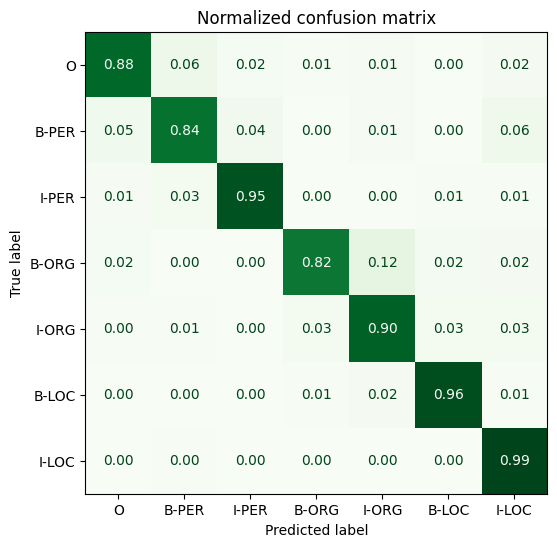

In [52]:
from sklearn.metrics import ConfusionMatrixDisplay, confusion_matrix
import matplotlib.pyplot as plt

def plot_confusion_matrix(y_preds, y_true, labels):
    cm = confusion_matrix(y_true, y_preds, normalize="true")
    fig, ax = plt.subplots(figsize=(6, 6))
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=labels)
    disp.plot(cmap="Greens", values_format=".2f", ax=ax, colorbar=False)
    plt.title("Normalized confusion matrix")
    plt.show()

plot_confusion_matrix(df_tokens["labels"], df_tokens["predicted_label"], reference_tags.names)

So we see that B-ORG is often confused with I-ORG

Let's now look at the SENTENCE level loss, after looking at token level:

In [53]:
def get_samples(df):
    for _, row in df.iterrows():
        labels, preds, tokens, losses = [], [], [], []
        for i, mask in enumerate(row["attention_mask"]):
            if i not in {0, len(row["attention_mask"])}:
                labels.append(row["labels"][i])
                preds.append(row["predicted_label"][i])
                tokens.append(row["input_tokens"][i])
                losses.append(f"{row['loss'][i]:.2f}")
        
        df_tmp = pd.DataFrame({"tokens": tokens, "labels": labels, "preds": preds, "losses": losses}).T
        
        yield df_tmp

df["total_loss"] = df["loss"].apply(sum)
df_tmp = df.sort_values(by="total_loss", ascending=False).head(3)

for sample in get_samples(df_tmp):
    display(sample)

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18
tokens,▁',▁'',▁Τ,Κ,▁'',▁',▁',▁'',▁T,▁'',▁',ri,▁'',▁',k,▁'',▁',ala,</s>
labels,O,O,O,IGN,O,O,B-LOC,I-LOC,I-LOC,I-LOC,I-LOC,IGN,I-LOC,I-LOC,IGN,I-LOC,I-LOC,IGN,IGN
preds,O,O,B-ORG,I-ORG,O,O,O,O,O,O,O,O,O,O,O,O,O,O,O
losses,0.00,0.00,4.06,0.00,0.00,0.00,10.65,9.93,8.22,8.11,8.16,0.00,8.17,8.73,0.00,8.73,8.79,0.00,0.00


,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17
tokens,▁'',8,.,▁Juli,▁'',▁:,▁Protest,camp,▁auf,▁dem,▁Gelände,▁der,▁Republika,n,ischen,▁Gar,de,</s>
labels,B-ORG,IGN,IGN,I-ORG,I-ORG,I-ORG,I-ORG,IGN,I-ORG,I-ORG,I-ORG,I-ORG,I-ORG,IGN,IGN,I-ORG,IGN,IGN
preds,O,O,O,O,O,O,O,O,O,O,O,O,B-ORG,I-ORG,I-ORG,I-ORG,I-ORG,O
losses,8.45,0.00,0.00,6.86,8.47,8.42,6.51,0.00,7.06,8.24,6.77,4.54,4.63,0.00,0.00,0.01,0.00,0.00


,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14
tokens,▁United,▁Nations,▁Multi,dimensional,▁Integra,ted,▁Stabil,ization,▁Mission,▁in,▁the,▁Central,▁African,▁Republic,</s>
labels,B-PER,I-PER,I-PER,IGN,I-PER,IGN,I-PER,IGN,I-PER,I-PER,I-PER,I-PER,I-PER,I-PER,IGN
preds,B-ORG,I-ORG,I-ORG,I-ORG,I-ORG,I-ORG,I-ORG,I-ORG,I-ORG,I-ORG,I-ORG,I-ORG,I-ORG,I-ORG,I-ORG
losses,7.31,6.30,6.22,0.00,6.13,0.00,6.08,0.00,6.01,5.48,5.92,6.47,6.33,6.24,0.00


In [54]:
# In the above we see an explanation for why these sentences are bad -
# we note for ex that Central African Republic is annotated as PER, 8 Juli is annotated ORG etc
""" It turns out the annotations for the PAN-X dataset were generated through an automated process.
Such annotations are often referred to as “silver standard” (in contrast to the “gold
standard” of human-generated annotations), and it is no surprise that there are cases
where the automated approach failed to produce sensible labels. In fact, such failure
modes are not unique to automatic approaches; even when humans carefully anno‐
tate data, mistakes can occur when the concentration of the annotators fades or they
simply misunderstand the sentence."""

# we saw parens and slashes had high losses - here are sentences starting with them:
df_tmp = df.loc[df["input_tokens"].apply(lambda x: u"\u2581(" in x)].head(2)
for sample in get_samples(df_tmp):
    display(sample)

,0,1,2,3,4,5
tokens,▁Ham,a,▁(,▁Unternehmen,▁),</s>
labels,B-ORG,IGN,I-ORG,I-ORG,I-ORG,IGN
preds,B-ORG,I-ORG,I-ORG,I-ORG,I-ORG,I-ORG
losses,0.01,0.00,0.01,0.01,0.01,0.00


,0,1,2,3,4,5,6,7
tokens,▁Kesk,kül,a,▁(,▁Mart,na,▁),</s>
labels,B-LOC,IGN,IGN,I-LOC,I-LOC,IGN,I-LOC,IGN
preds,B-LOC,I-LOC,I-LOC,I-LOC,I-LOC,I-LOC,I-LOC,I-LOC
losses,0.02,0.00,0.00,0.02,0.02,0.00,0.02,0.00


In [55]:
"""In general we would not include the parentheses and their contents as part of the
named entity, but this seems to be the way the automatic extraction annotated the
documents. In the other examples, the parentheses contain a geographic specification.
While this is indeed a location as well, we might want disconnect it from the original
location in the annotations. This dataset consists of Wikipedia articles in different
languages, and the article titles often contain some sort of explanation in parentheses."""

'In general we would not include the parentheses and their contents as part of the\nnamed entity, but this seems to be the way the automatic extraction annotated the\ndocuments. In the other examples, the parentheses contain a geographic specification.\nWhile this is indeed a location as well, we might want disconnect it from the original\nlocation in the annotations. This dataset consists of Wikipedia articles in different\nlanguages, and the article titles often contain some sort of explanation in parentheses.'

In [ ]:
# rest of chapter is traning on multilingual part 